In [5]:
import os
import time
import itertools

from torchvision.transforms import v2
from sklearn.model_selection import train_test_split, StratifiedKFold
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from PIL import Image
import tqdm.notebook as tqdm
from IPython import display
import gc 

%load_ext autoreload
%autoreload 2
    
from data_loaders import *
from training_utils import *
from cnn_model import *
from vae_model import *

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
torchvision.disable_beta_transforms_warning()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_dataset_preview(dataset, idxs, title, sample_idxs, nrows, ncols, ax, idx_to_plot=0):
    imgs = np.zeros((nrows * 32, ncols * 32))
    assert len(sample_idxs) == nrows * ncols
    xy_indices = itertools.product(range(nrows), range(ncols))
    for i, (row, col) in enumerate(xy_indices):
        idx = sample_idxs[i]
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[row*32:(row+1)*32, col*32:(col+1)*32] = curr.numpy()
    ax.imshow(imgs, vmin=-1, vmax=1, cmap='icefire')
    ax.set_title(title)

def get_pixel_dist(dataset, idxs, title, sample_idxs, ax, idx_to_plot=0):
    imgs = np.empty((nsamples, 32, 32))
    for i, idx in enumerate(sample_idxs):
        X, Y = dataset[idx]
        curr = X[idx_to_plot].reshape(32,32)
        imgs[i] = curr.numpy()
    sns.histplot(imgs.ravel(), stat='density', ax=ax, label=idx_to_plot, binrange=[-1,1])
    ax.legend()
    ax.set_title(title)


def get_cloudy_stats(data, idx):
    filtered_data = data.iloc[idx]
    clear_data = filtered_data.loc[filtered_data['label'] == 'clear_night_sky']
    cloudy_data = filtered_data.loc[filtered_data['label'] == 'not_clear_cloudy']
    prop_clear = len(clear_data) / len(filtered_data)
    prop_cloudy = len(cloudy_data) / len(filtered_data)
    return len(cloudy_data), prop_cloudy


def print_class_dist(data, idx, name):
    filtered_data = data.iloc[idx]
    ncloudy, prop_cloudy = get_cloudy_stats(data, idx)
    unique_module_ids = list(np.sort(filtered_data["module_id"].unique()))
    print(f'Percent cloudy (in {name}) = {100 * prop_cloudy:.3f}% ({ncloudy} / {len(filtered_data)}); '
          f'Unique module_ids: {unique_module_ids}')



In [7]:
test_prop = 0.3
nfolds = 5
# boundary_prop = 0.1 # Proportion of data to discard between the validation and train_proportions (time)
batch_size = 128
random_seed = 35


# Creating the datasets
# mean = [7.4, 0, 0]
# std = [5.5, 60, 75]

# mean = [7.4, 0, 0, 7.4]
# std = [5.5, 60, 75, 5.5]

mean = [7.4, 7.4]
std = [5.5, 5.5] 

# Create test/train split
transform = v2.Compose([
    v2.ToTensor(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])

train_labeled_data = CloudDetectionTrain(transform=transform)

target_transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=mean, std=std),
    v2.ToDtype(torch.float),
])

test_labeled_data = CloudDetectionTrain(target_transform=target_transform)

# dsl = train_labeled_data.dsl_df
# dataset_size = len(dsl)

# # Split data
# all_idxs = np.arange(dataset_size)
# y_labels = dsl['label'].map(
#     {
#         "clear_night_sky": 0,
#         "not_clear_cloudy": 1
#     }
# )

# train_split_idxs, test_split_idxs, y_train, y_test = train_test_split(
#     all_idxs,
#     y_labels,
#     test_size=test_prop,
#     random_state=random_seed,
#     stratify=y_labels
# )

# test_loader = torch.utils.data.DataLoader(
#   dataset=test_labeled_data,
#   batch_size=batch_size,
#   sampler=torch.utils.data.SubsetRandomSampler(test_split_idxs)
# )

# train_loader = torch.utils.data.DataLoader(
#   dataset=train_labeled_data,
#   batch_size=batch_size,
#   sampler=torch.utils.data.SubsetRandomSampler(train_split_idxs)
# )


# # Get dataset stats
# print(
#     f'test_prop (of dataset) = {100 * len(test_split_idxs) / dataset_size:.2f}%\n'
#     f'train_prop (of dataset) = {100 * len(train_split_idxs) / dataset_size:.2f}%\n'
# )
# print_class_dist(dsl, test_split_idxs, 'test')
# print_class_dist(dsl, train_split_idxs, 'train')
# print_class_dist(dsl, dsl.index, 'overall')

test_prop (of dataset) = 30.00%
train_prop (of dataset) = 70.00%

Percent cloudy (in test) = 53.955% (3765 / 6978); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 53.965% (8786 / 16281); Unique module_ids: [1, 3, 254]
Percent cloudy (in overall) = 53.962% (12551 / 23259); Unique module_ids: [1, 3, 254]


Fold 0:
  Train: index=[    0     2     3 ... 16276 16279 16280]
  Val:  index=[    1     4     8 ... 16275 16277 16278]
Fold 1:
  Train: index=[    0     1     2 ... 16277 16278 16280]
  Val:  index=[    6     7    27 ... 16271 16276 16279]
Fold 2:
  Train: index=[    0     1     2 ... 16278 16279 16280]
  Val:  index=[    5    10    11 ... 16266 16268 16273]
Fold 3:
  Train: index=[    0     1     2 ... 16277 16278 16279]
  Val:  index=[    3     9    14 ... 16261 16272 16280]
Fold 4:
  Train: index=[    1     3     4 ... 16278 16279 16280]
  Val:  index=[    0     2    12 ... 16269 16270 16274]


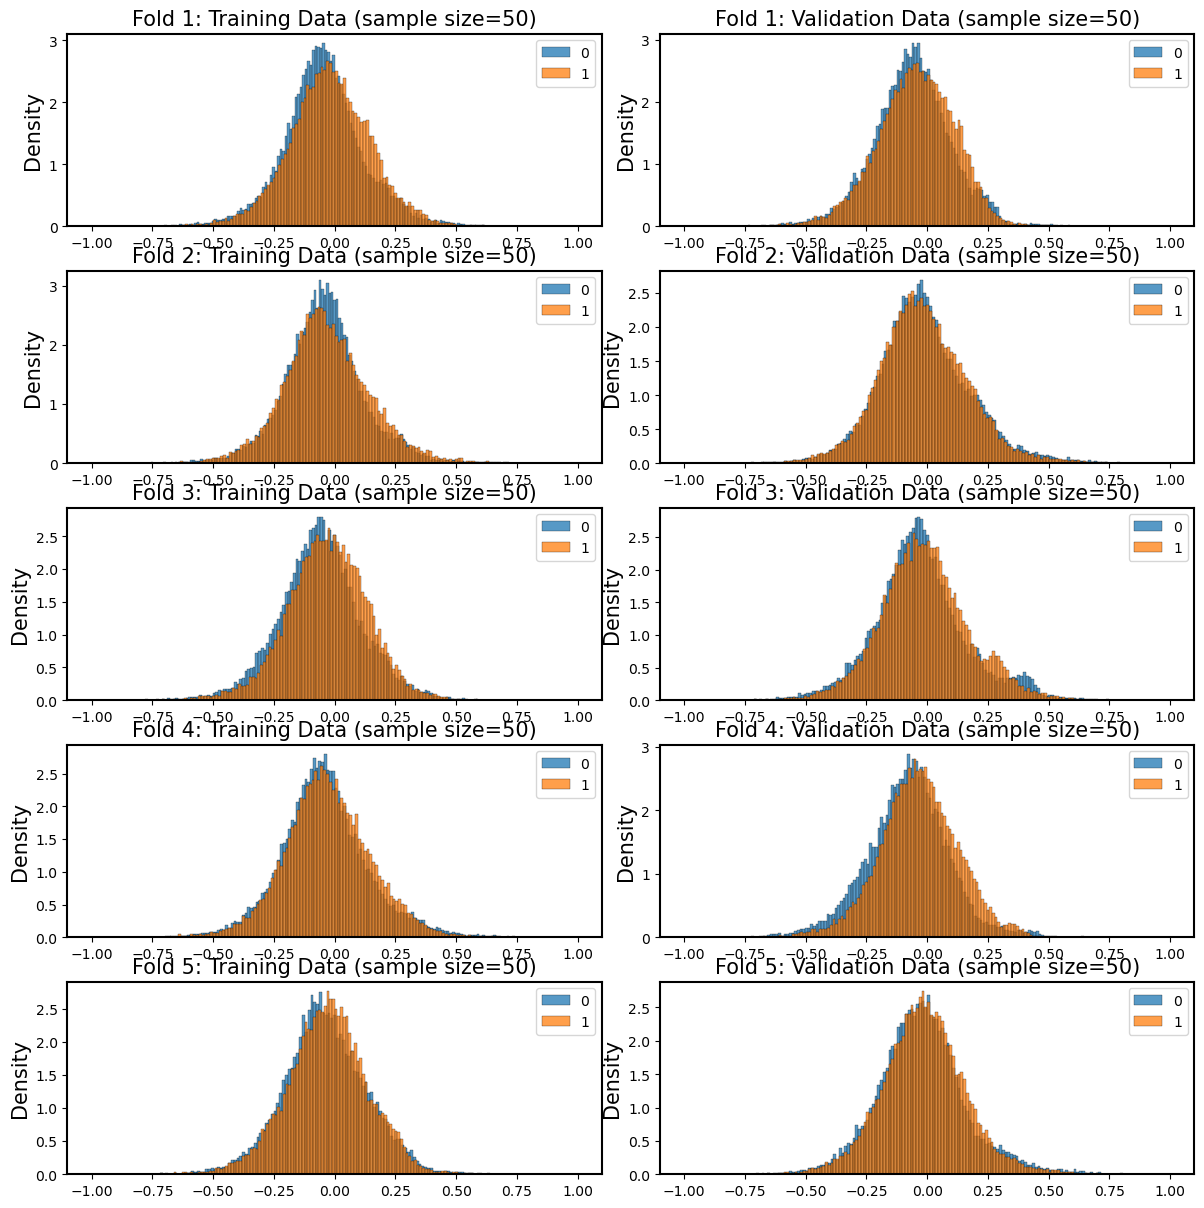

In [8]:
fig, axs = plt.subplots(nfolds, 2, figsize=(12, 12))
fig.tight_layout()

skf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=random_seed)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_split_idxs, y_train)):
    print(f"Fold {fold_idx}:")
    print(f"  Train: index={train_idx}")
    print(f"  Val:  index={val_idx}")

    nrows, ncols = 5, 10
    
    nsamples = nrows * ncols
    train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
    val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)

    if len(train_sample_idxs) < nsamples:
        print('Not enough training data')
        break
    elif len(val_sample_idxs) < nsamples:
        print('Not enough validation data')
        break
    
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=0
    )
    get_pixel_dist(
        train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
        sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=1
    )
    # get_pixel_dist(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=2
    # )
    # get_pixel_dist(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     sample_idxs=train_sample_idxs, ax=axs[fold_idx][0], idx_to_plot=3
    # )

    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=0
    # )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=1
    # )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=2
    # )
    # get_pixel_dist(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     sample_idxs=val_sample_idxs, ax=axs[fold_idx][1], idx_to_plot=3
    # )
    
    # get_dataset_preview(
    #     train_labeled_data, train_idx, title=f'Fold {fold_idx + 1}: Training Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][0], idx_to_plot=1
    # )
    # get_dataset_preview(
    #     test_labeled_data, val_idx, title=f'Fold {fold_idx + 1}: Validation Data (sample size={nrows*ncols})',
    #     nrows=nrows, ncols=ncols, ax=axs[fold_idx][1], idx_to_plot=1
    # )
plt.show(fig)
plt.close()

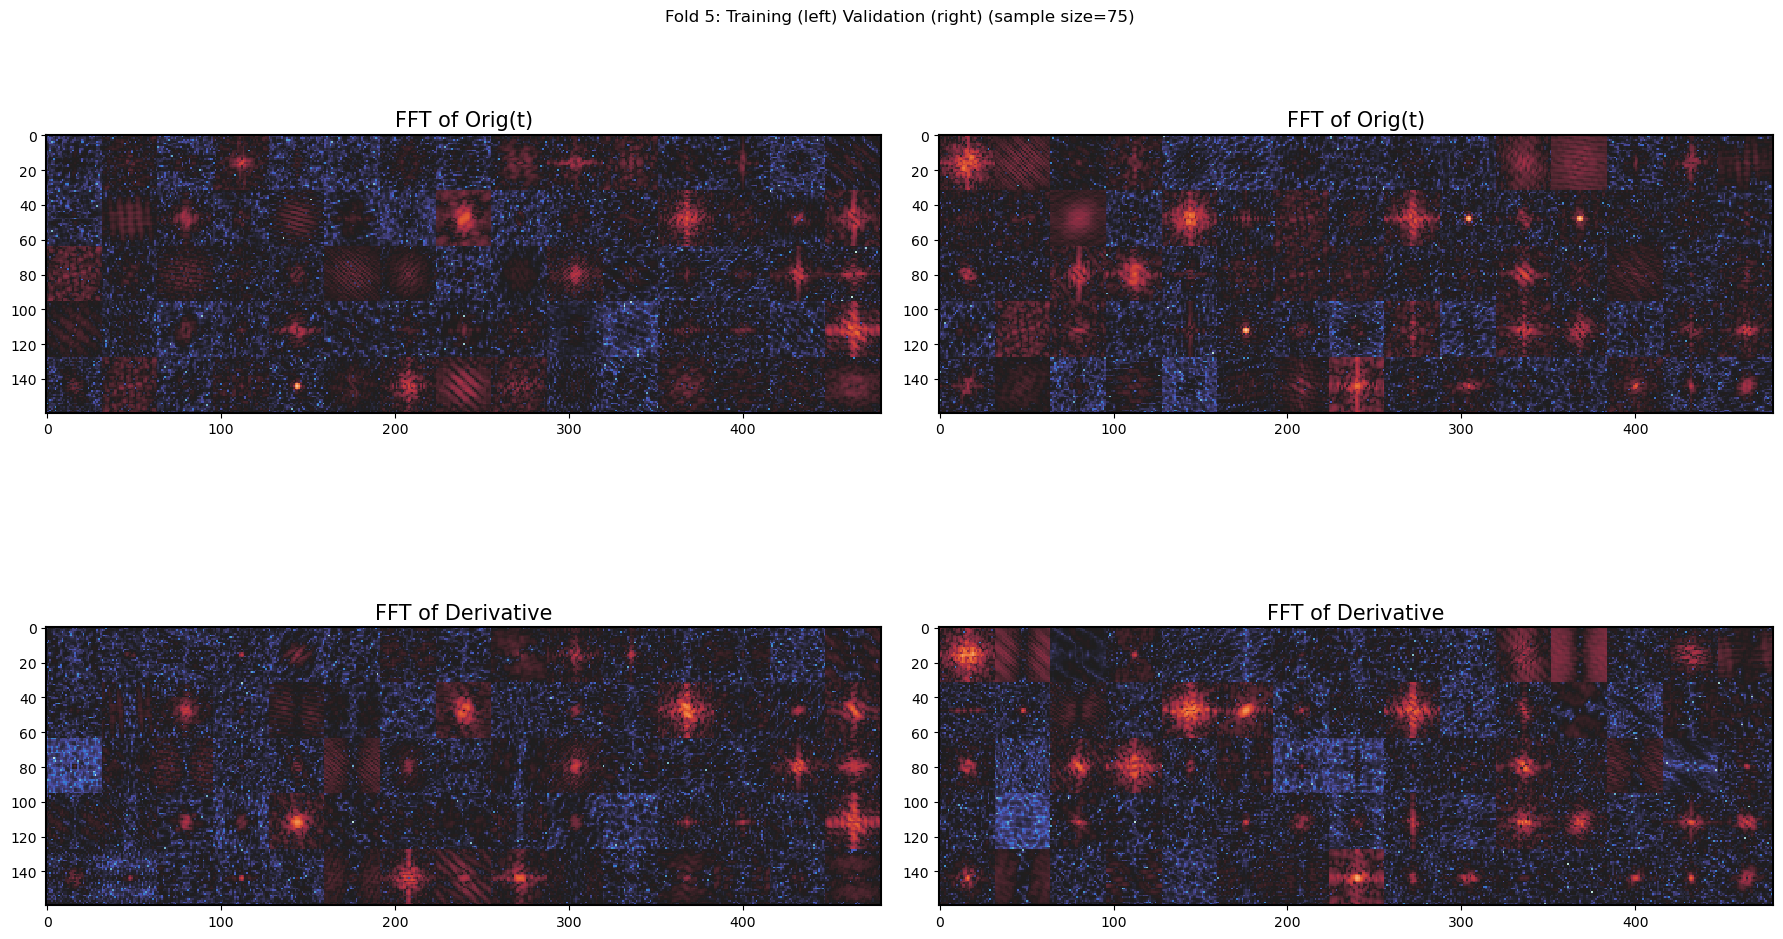

In [9]:
nrows, ncols = 5, 15
data_fig, data_axs = plt.subplots(2, 2, figsize=(ncols*1.2, nrows*2))
data_fig.tight_layout()

nsamples = nrows * ncols
train_sample_idxs = np.random.choice(train_idx, nsamples, replace=False)
val_sample_idxs = np.random.choice(val_idx, nsamples, replace=False)

if len(train_sample_idxs) < nsamples:
    print('Not enough training data')
elif len(val_sample_idxs) < nsamples:
    print('Not enough validation data')

# img_types = {
#     0: 'FFT of Derivative',
#     1: 'Orig(t) @ 3ms',
#     2: 'Orig(t) - Orig(t-60s)',
#     3: 'FFT of Orig(t)'
# }

img_types = {
    0: 'FFT of Derivative',
    1: 'FFT of Orig(t)'
}

data_fig.suptitle(f'Fold {fold_idx + 1}: Training (left) Validation (right) (sample size={nrows*ncols})', y=1.02)
for img_type_idx in range(1, 3):
    img_type_idx = img_type_idx % 2
    img_type = img_types[img_type_idx]
    get_dataset_preview(
        test_labeled_data, train_idx, title=img_type,
        sample_idxs=train_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][0], idx_to_plot=img_type_idx
    )
    get_dataset_preview(
        test_labeled_data, val_idx, title=img_type,
        sample_idxs=val_sample_idxs, nrows=nrows, ncols=ncols, ax=data_axs[img_type_idx - 1][1], idx_to_plot=img_type_idx
    )
plt.show(data_fig)
plt.close(data_fig)

In [16]:
# Example usage
if __name__ == "__main__":
    # Initialize the VAE
    vae = VaeModel(latent_dim=16)
    print(vae)

    # Example input
    x = torch.randn(8, 1, 32, 32)  # Batch of 8 grayscale images
    recon_x, mu, logvar = vae(x)
    
    # Compute the loss
    loss = vae_loss(recon_x, x, mu, logvar)
    print(f"Loss: {loss.item()}")

VaeModel(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=2048, out_features=16, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=16, bias=True)
  (fc_dec): Linear(in_features=16, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): Sigmoid()
  )
)
Loss: 10729.259765625


In [17]:
# Training helper functions
def make_training_psnr_plot(log_dict, figsize=(9,6)):
    """Plot training loss vs step"""
    epoch = log_dict['Epoch'][-1]
    log_df = pd.DataFrame.from_dict(log_dict)
    plt.figure(figsize=figsize)
    sns.lineplot(
        log_df,
        x='Step',
        y='Loss',
        errorbar=None,
    )
    ax = plt.gca()
    ax.set_ylabel('Loss')
    ax.set_yscale('log')
    plt.grid(True, which="both", ls="-")
    plt.title(f'Training Loss After {epoch} Epochs')
    plt.show()

def get_device(verbose=False):
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    if verbose: print(f"Using device {device}")
    return device

In [18]:
# Forward method
def vae_forward(
    vae: VaeModel,
    X: torch.Tensor,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        X: (N, 32, 32) input tensor of 1x32x32 images

    Returns:
        (,) vae loss.
    """
    # Apply positional encoding to input coordinates
    vae.train()
    recon_x, mu, logvar = vae.forward(X)
    return vae_loss(recon_x, x, mu, logvar)

# Sampling method
@torch.inference_mode()
def vae_sample(
    vae: VaeModel,
    nsamples: int,
    img_wh: tuple[int, int],
    seed: int = 180,
) -> torch.Tensor:
    """
    Args:
        vae: VAE model
        nsamples: number of images to create
        img_wh: image dimensions (W, H)
    Returns:
        (,) 
    """
    vae.eval()
    with torch.no_grad():
        z = torch.randn(nsamples, vae.latent_dim)
        sampled_images = vae.decode(z)
    return sampled_images

In [ ]:
# VAE model

class VaeWrapper(nn.Module):
    def __init__(
        self,
        vae: VaeModel,
        input_img_wh: tuple[int, int] = (32, 32),
    ):
        super().__init__(),
        self.vae = vae
        self.img_wh = input_img_wh
        
    def forward(self, X: torch.Tensor):
        """
        Args:
            X: (N, 32, 32) input tensor of 1x32x32 images

        Returns:
            (,) VAE loss.
        """
        assert x[0].shape == torch.Size(self.img_wh)
        self.vae.train()
        return vae_forward(self.vae, X)

    @torch.inference_mode()
    def sample(
        self,
        nsamples: int = 16,
        seed: int = 180,
    ):
        self.vae.eval()
        return vae_sample(self.vae, self.img_wh, seed)

In [ ]:
# Train Neural Field TODO: fix it.
hyperparam_config = {
    'latent_dim': 256,
    'num_epochs': 50,
    'batch_size': 128,
    'gamma': 0.95,
    'lr': 1e-2,
    'weight_decay': 1e-5,
}

def train_vae(
    hpc,
    seed = 180,
    verbose=True,
):   
    device = get_device()
    torch.manual_seed(seed)
    
    ####### Panoseti dataloader
    mean = [7.4, 7.4]
    std = [5.5, 5.5] 
    
    transform = v2.Compose([
        v2.ToTensor(),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.RandomHorizontalFlip(),
        v2.RandomVerticalFlip(),
        v2.Normalize(mean=mean, std=std),
        v2.ToDtype(torch.float),
    ])
    
    train_labeled_data = CloudDetectionTrain(transform=transform)
    
    train_loader = torch.utils.data.DataLoader(
        dataset = train_labeled_data,
        batch_size = hpc['batch_size'],
        shuffle = True,
    )
    

    # Model vars
    model = VAE(
        vae = VaeModel(hpc['latent_dim']),
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=hpc['lr'])
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    
    # Samples the first batch of data.
    images, labels = next(iter(train_loader))
    show_image_grid(images, nrow=32)
    
    log_dict = {
        'Step': [],
        'Loss': [],
        'Epoch': []
    }
    return 
    step = 0
    for epoch in range(1, hpc['num_epochs'] + 1):
        torch.manual_seed(2024 + epoch)
        for x, c in tqdm(train_loader, unit="batch"):
            step += 1
            model.train()
            # print(len(x.shape)
            x = x.to(device)
            c = c.to(device)

            optimizer.zero_grad()
            loss = model(x, c)
            loss.backward()
            optimizer.step()
    
            if step % 5 == 0: 
                log_dict['Epoch'].append(epoch)
                log_dict['Step'].append(step)
                log_dict['Loss'].append(np.abs(loss.item()))
        
        # Update learning rate
        # scheduler.step()
        
        # Make figures for this Epoch
        print(f'Epoch {epoch}\n')
        if (epoch - 1) % 5 == 0: 
            plot_sample(model)
            os.makedirs('vae_model')
            save_model(model, f"vae_model/vae_nepoch={epoch}_nhiddens={n_hidden}")
        if (epoch - 1) % 20 == 0:
            make_training_psnr_plot(log_dict)
    
    log_df = pd.DataFrame.from_dict(log_dict)
    make_training_psnr_plot(log_dict)
    plot_sample(model)
    return model, log_df

In [39]:
# Train full model

# Training config
learning_rate = 0.001
weight_decay = 1e-5
epochs = 50
gamma = 0.9
batch_size = 128
# momentum=0.9


test_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(test_split_idxs)
)

train_loader = torch.utils.data.DataLoader(
  dataset=train_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.SubsetRandomSampler(train_split_idxs)
)

# To satisfy train function signature
val_loader = torch.utils.data.DataLoader(
  dataset=test_labeled_data,
  batch_size=batch_size,
  sampler=torch.utils.data.sampler.SubsetRandomSampler(np.random.choice(train_split_idxs, size=int(len(train_split_idxs) * 0.05)))
)


# Get dataset stats
print(
    f'test_prop (of dataset) = {100 * len(test_split_idxs) / dataset_size:.2f}%\n'
    f'train_prop (of dataset) = {100 * len(train_split_idxs) / dataset_size:.2f}%\n'
    f'val_prop (of trainset) = {100 * len(val_loader) / (len(val_loader) + len(train_split_idxs)):.2f}%'
)
print_class_dist(dsl, test_split_idxs, 'test')
print_class_dist(dsl, train_split_idxs, 'train')
print_class_dist(dsl, dsl.index, 'overall')


model = CloudDetection()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-6)#, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.CrossEntropyLoss()


trainer = Trainer(
    model, optimizer, loss_fn, train_loader, val_loader,
    epochs=epochs, gamma=gamma, do_summary=True
);
gc.collect();

test_prop (of dataset) = 30.00%
train_prop (of dataset) = 70.00%
val_prop (of trainset) = 0.04%
Percent cloudy (in test) = 53.955% (3765 / 6978); Unique module_ids: [1, 3, 254]
Percent cloudy (in train) = 53.965% (8786 / 16281); Unique module_ids: [1, 3, 254]
Percent cloudy (in overall) = 53.962% (12551 / 23259); Unique module_ids: [1, 3, 254]
torch.Size([128, 2, 32, 32])
(2, 32, 32)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 28, 10, 10]          --
|    └─Conv2d: 2-1                       [-1, 28, 32, 32]          280
|    └─ReLU: 2-2                         [-1, 28, 32, 32]          --
|    └─BatchNorm2d: 2-3                  [-1, 28, 32, 32]          56
|    └─Dropout2d: 2-4                    [-1, 28, 32, 32]          --
|    └─Conv2d: 2-5                       [-1, 28, 32, 32]          3,556
|    └─ReLU: 2-6                         [-1, 28, 32, 32]          --
|    └─BatchNorm2d: 2-7                  [-1



Epoch 1


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.6886,  acc = 430/814 (52.83%) 



Epoch 2


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.6281,  acc = 664/814 (81.57%) 



Epoch 3


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3998,  acc = 752/814 (92.38%) 



Epoch 4


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3971,  acc = 768/814 (94.35%) 



Epoch 5


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3361,  acc = 770/814 (94.59%) 



Epoch 6


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3470,  acc = 772/814 (94.84%) 



Epoch 7


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3519,  acc = 779/814 (95.70%) 



Epoch 8


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3663,  acc = 778/814 (95.58%) 



Epoch 9


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3479,  acc = 778/814 (95.58%) 



Epoch 10


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3565,  acc = 779/814 (95.70%) 



Epoch 11


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3593,  acc = 777/814 (95.45%) 



Epoch 12


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3544,  acc = 777/814 (95.45%) 



Epoch 13


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3516,  acc = 777/814 (95.45%) 



Epoch 14


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3455,  acc = 779/814 (95.70%) 



Epoch 15


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3670,  acc = 780/814 (95.82%) 



Epoch 16


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3409,  acc = 780/814 (95.82%) 



Epoch 17


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3374,  acc = 784/814 (96.31%) 



Epoch 18


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3307,  acc = 779/814 (95.70%) 



Epoch 19


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3466,  acc = 779/814 (95.70%) 



Epoch 20


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3407,  acc = 779/814 (95.70%) 



Epoch 21


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3461,  acc = 784/814 (96.31%) 



Epoch 22


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3521,  acc = 783/814 (96.19%) 



Epoch 23


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3446,  acc = 785/814 (96.44%) 



Epoch 24


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3427,  acc = 781/814 (95.95%) 



Epoch 25


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3477,  acc = 784/814 (96.31%) 



Epoch 26


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3463,  acc = 780/814 (95.82%) 



Epoch 27


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3531,  acc = 780/814 (95.82%) 



Epoch 28


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3488,  acc = 782/814 (96.07%) 



Epoch 29


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3471,  acc = 779/814 (95.70%) 



Epoch 30


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3429,  acc = 780/814 (95.82%) 



Epoch 31


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3500,  acc = 780/814 (95.82%) 



Epoch 32


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3467,  acc = 778/814 (95.58%) 



Epoch 33


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3441,  acc = 782/814 (96.07%) 



Epoch 34


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3451,  acc = 782/814 (96.07%) 



Epoch 35


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3497,  acc = 782/814 (96.07%) 



Epoch 36


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3579,  acc = 780/814 (95.82%) 



Epoch 37


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3424,  acc = 780/814 (95.82%) 



Epoch 38


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3494,  acc = 779/814 (95.70%) 



Epoch 39


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3436,  acc = 782/814 (96.07%) 



Epoch 40


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3464,  acc = 778/814 (95.58%) 



Epoch 41


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3486,  acc = 780/814 (95.82%) 



Epoch 42


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3464,  acc = 780/814 (95.82%) 



Epoch 43


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3515,  acc = 780/814 (95.82%) 



Epoch 44


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3513,  acc = 779/814 (95.70%) 



Epoch 45


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3347,  acc = 782/814 (96.07%) 



Epoch 46


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3468,  acc = 782/814 (96.07%) 



Epoch 47


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3457,  acc = 783/814 (96.19%) 



Epoch 48


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3400,  acc = 779/814 (95.70%) 



Epoch 49


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3502,  acc = 779/814 (95.70%) 



Epoch 50


  0%|          | 0/128 [00:00<?, ?batches/s]

       Val: 	loss = 0.3448,  acc = 779/814 (95.70%) 

Done training


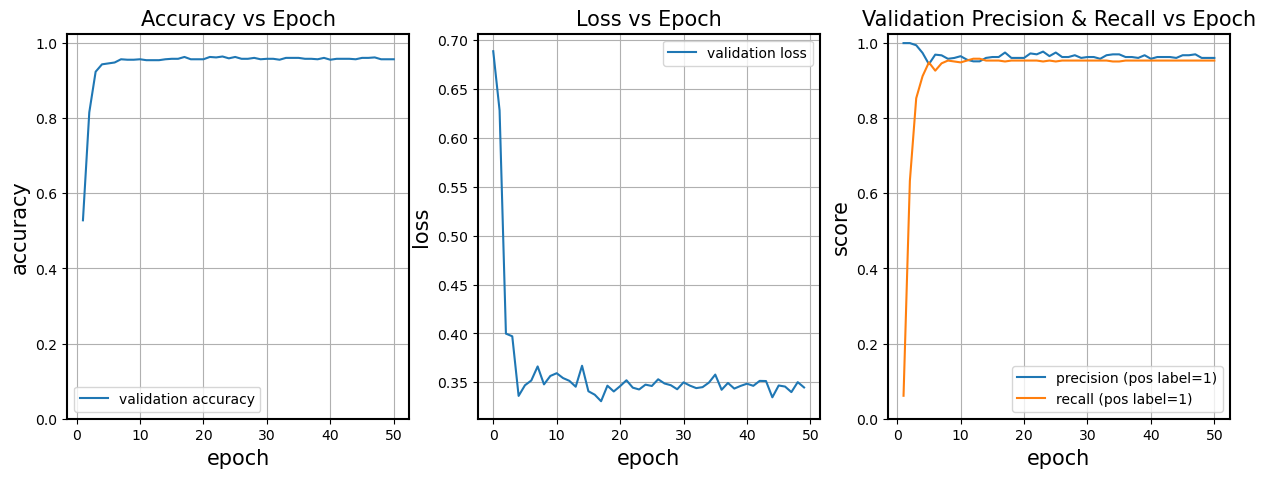

In [40]:
trainer.train(make_train_logs=False)

  0%|          | 0/55 [00:00<?, ?batches/s]

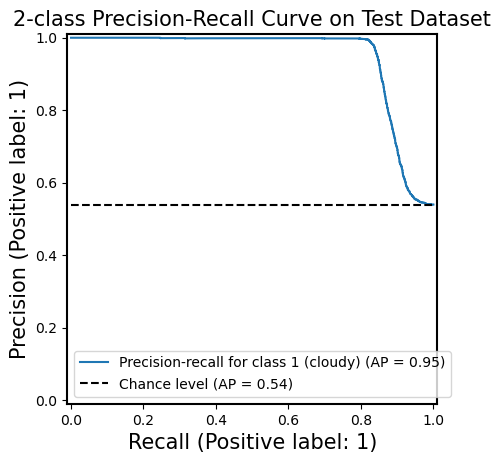

Test: 	loss = 0.3407,  acc = 6717/6978 (96.26%)


In [41]:
test_model = CloudDetection()
test_model.load_state_dict(torch.load('../model_training/best_cloud_detection_model.pth', weights_only=True))
loss_fn = nn.CrossEntropyLoss()
tester = Tester(test_model, loss_fn, test_loader)
tester.eval()